# Experiment Overview:

Goal: Compare the impact of different amounts of original and generated training data on a classifier 

used data: MNIST dataset, but only examples for the digits '6' and '8'

used metric: error of the classifier (TP + FP)/(TP + FP + TN + FN) for the given training data

used classifier: simple logistic regression (Barath will describe)

k is chosen from K = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120]

a DCGAN is trained on the k original samples for either 6 or 8. After training for 100 epochs, the DCGAN generates 20480 examples based on random input noise.

the k originals are combined with m generated examples to form the training set. m is chosen from M =  [0, 10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480]

the classifier is provided with the k original and m generated examples as a training set. After training the classifier, it is asked to classify all test examples of digit '6' and '8' of the original MNIST dataset, each 974 examples for '6' and '8'.

We repeat this process 10 times, each time training a new DCGAN with randomly initialized weights.

This results in:

10 * 2 * |K| = 200 trained DCGANS. *2 because one for each digit

10 * 2 * |K| * max(M) = 4096000 examples are generated in total

10 * |K| * |M| = 1300 classifiers are trained and tested on the test data 

As an additional experiment, to get an understanding of the subjective quality measured in how "real" the generated examples look to humans, describe the little humanDiscriminator experiment and that we measure quality as accuracy of a human when discriminating between originals and samples. A low accuracy corresponds to very good generated data. A accuracy of 50% means the generated data is not distinuishable from real data anymore.

# Results:

Short section to describe how well humans were able to distinguish between original and generated examples. Emphasize that the generation is much more likely to be a success here, if there is a large k provided. We should mention here, that for small k the network sometimes fails entirely to learn how to generate data, as it happened in the 9th iteration of generating 8s based on 10 originals. 

Then describe the effect of k on the test error. For k=10 obviously a large benefit of adding some generated examples. Diminishing return for additional generated data. I think the outliers (crosses) are from mentioned 9th iteration, but we need to confirm that. For all the different ks we can describe the development of median, mean, min, max and standard deviation of the error. I think we should check for each k, if the outliers come from the same iteration, this might be a indicator for failed DCGANS. We should mention that it is not always beneficial to add more generated data, especially for k >= 320 we can see that in many cases additional generated data increased the error. Standard deviation of error is much higher for large m.

Similarly describe the effect of m. To compare if m or k have a stronger effect, we could calculate the correlation of m and k and the error? I think the focus should be on k, since this is the number given in real-life scenarios. But let's still look at the interesting links between m and the error.

Then we show the 3D plot of both k and m and describe it, referencing the insights from the previous paragraphs.

I think an important part of our conclusion is, that adding generating data is very *promising*, but can sometimes even be harmful (e.g. when the GAN fails to converge and just generates non-sense, see the outliers). The results often vary quite a lot depending on the initial weights of the GAN. The obvious recommendation here is, to use a validation set that compares the error for data generated from several random GANs and also for different amounts of m. 

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with open('experimentResults.pickle', 'rb') as input:
    results = pickle.load(input)

    
# print number of iterations:
print(results['iterations'])
# print list of used ks (number of original samples):
print(results['ks'])
# print list of used ms (number of generated samples):
print(results['ms'])

# confusion matrix of 1st iteration, 80 originals, 0 generated
print(results[1][80][0])

10
[10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120]
[0, 10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480]
{'TN': 938, 'FP': 25, 'TP': 949, 'FN': 36}


In [4]:
def cmToMeasures(i, k, m):
    cm = results[i][k][m]
    TP = cm['TP']
    FP = cm['FP']
    TN = cm['TN']
    FN = cm['FN']
    accuracy = float(TP + TN) / (TP + FP + TN + FN)
    error = float(FP + FN) / (TP + FP + TN + FN)
    return [accuracy, error]

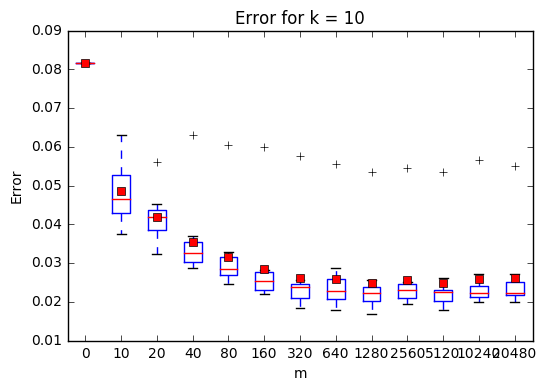

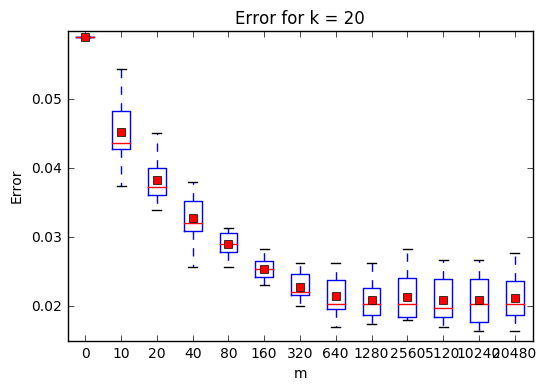

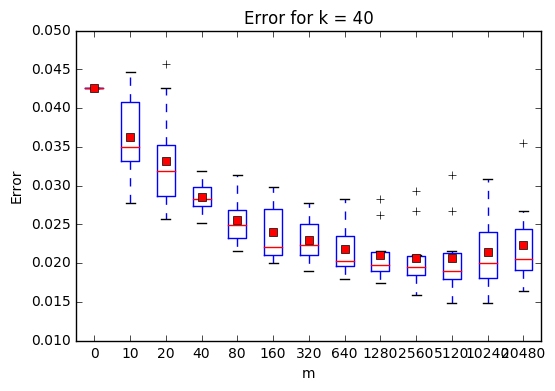

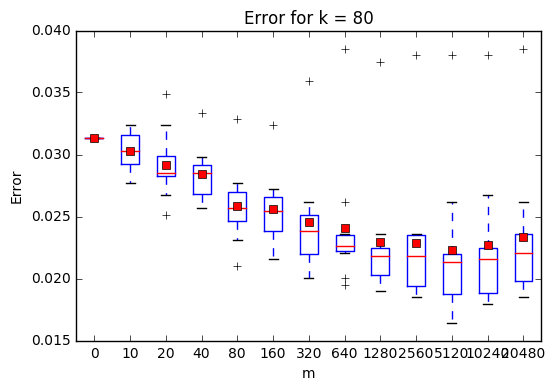

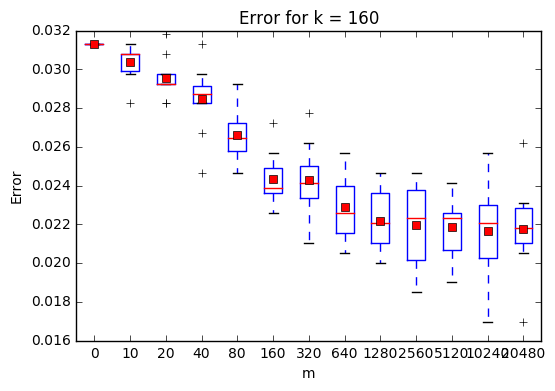

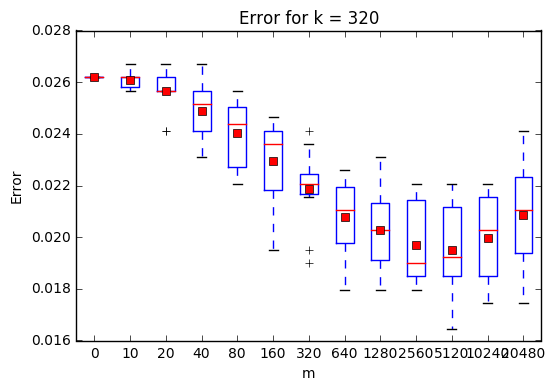

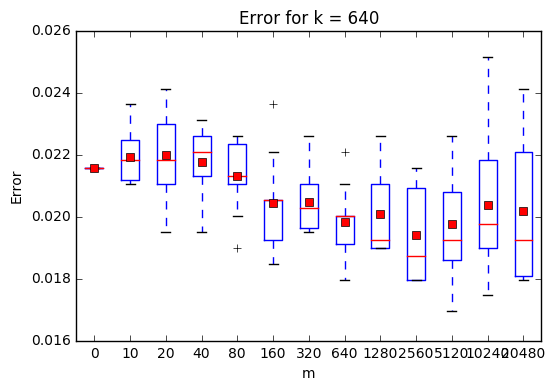

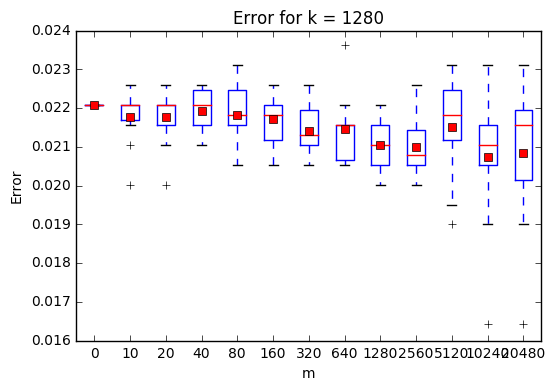

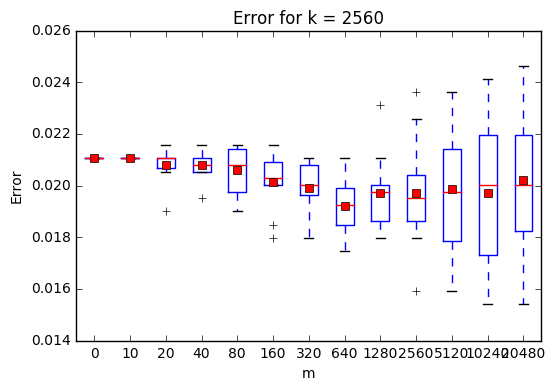

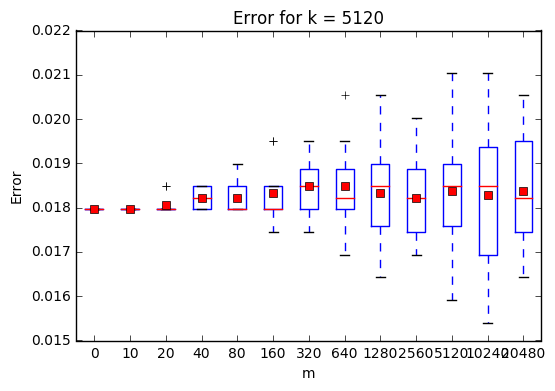

In [5]:
for k in results['ks']:
    data = []
    for i in range(1,results['iterations']+1):
        iterationRes = []
        for m in results['ms']:
            [accuracy, error] = cmToMeasures(i, k, m)
            iterationRes.append(error)
        data.append(iterationRes)


    data = np.array(data)
    fig, ax1 = plt.subplots()
    ax1.set_axisbelow(True)
    ax1.set_title('Error for k = ' +str(k))
    ax1.set_xlabel('m')
    ax1.set_ylabel('Error')
    plt.boxplot(data, showmeans=True)
    plt.xticks(range(1,(len(results['ms'])+1)), results['ms'])
    plt.show()
    

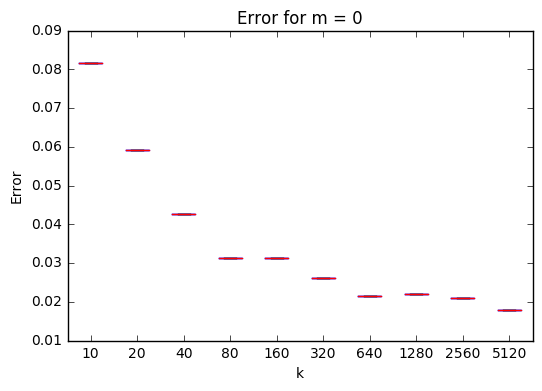

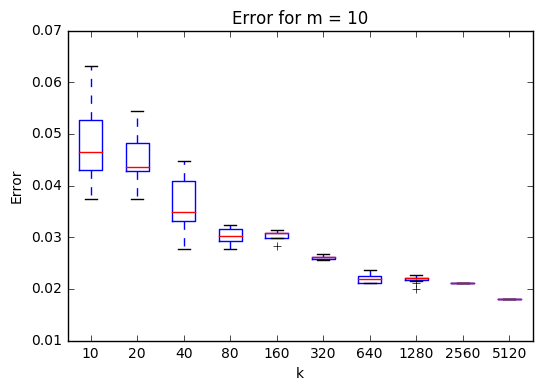

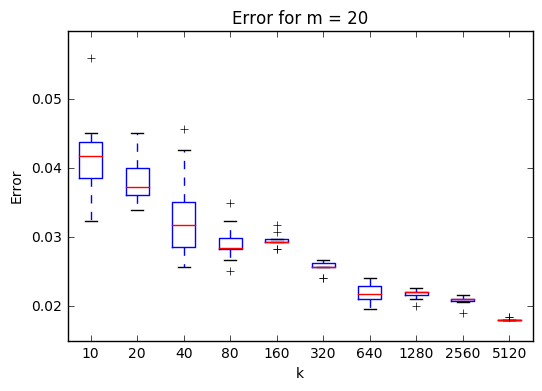

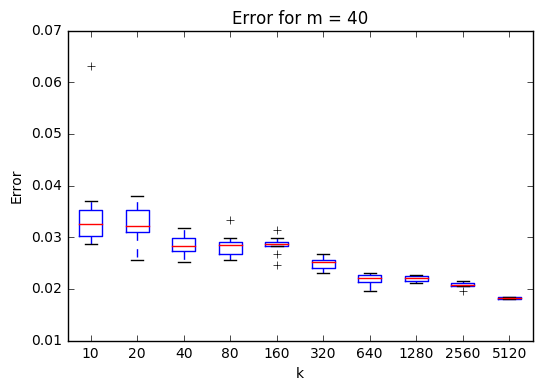

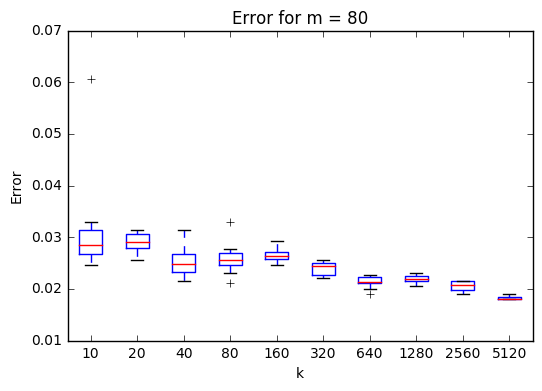

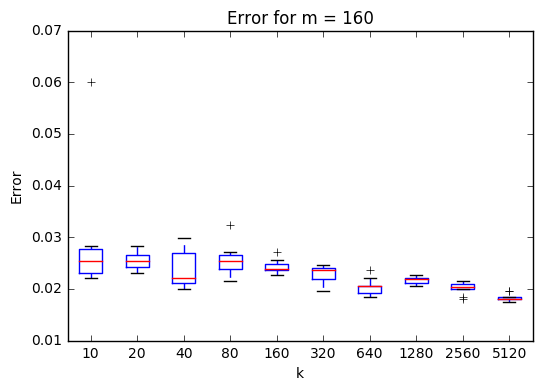

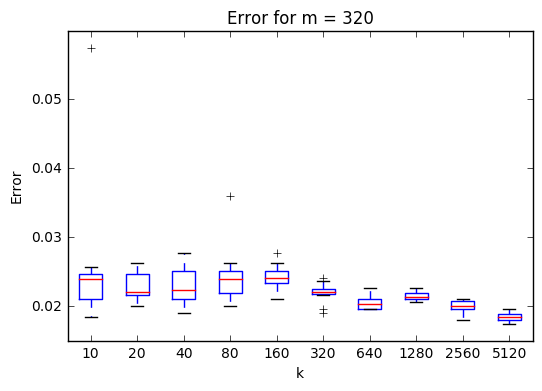

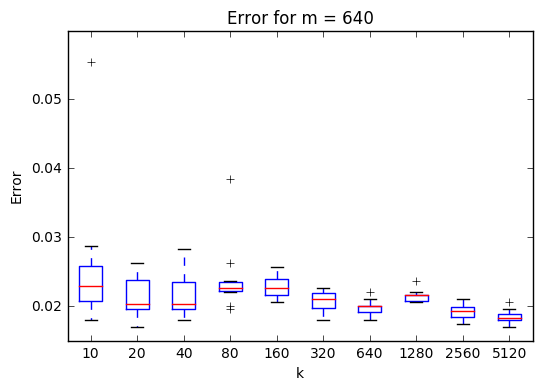

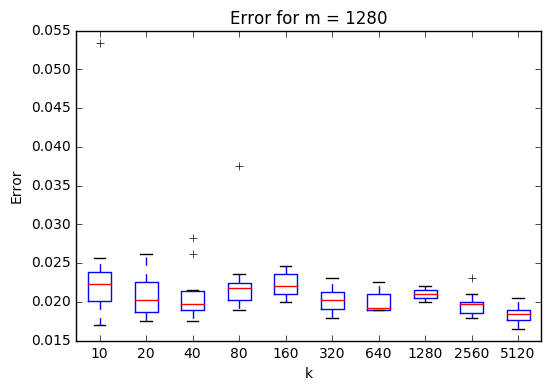

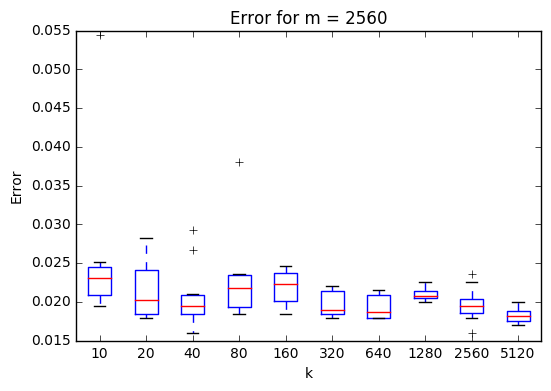

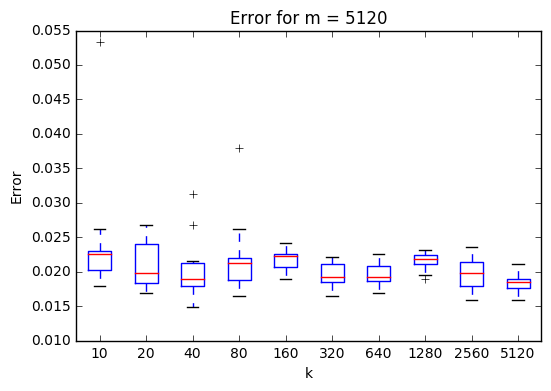

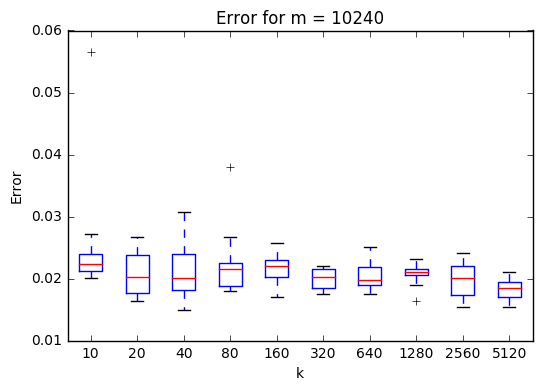

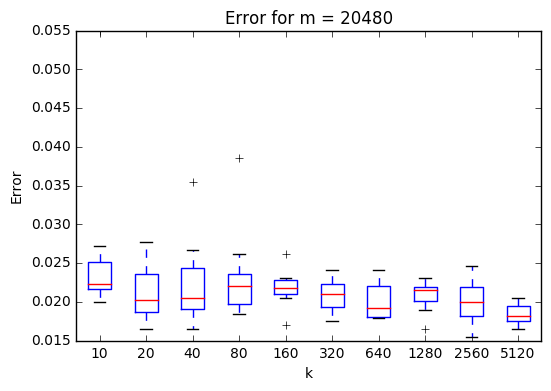

In [5]:
for m in results['ms']:
    data = []
    for i in range(1,results['iterations']+1):
        iterationRes = []
        for k in results['ks']:
            [accuracy, error] = cmToMeasures(i, k, m)
            iterationRes.append(error)
        data.append(iterationRes)

    data = np.array(data)
    fig, ax1 = plt.subplots()
    ax1.set_axisbelow(True)
    ax1.set_title('Error for m = ' +str(m))
    ax1.set_xlabel('k')
    ax1.set_ylabel('Error')
    plt.boxplot(data)
    plt.xticks(range(1,(len(results['ks'])+1)), results['ks'])
    plt.show()

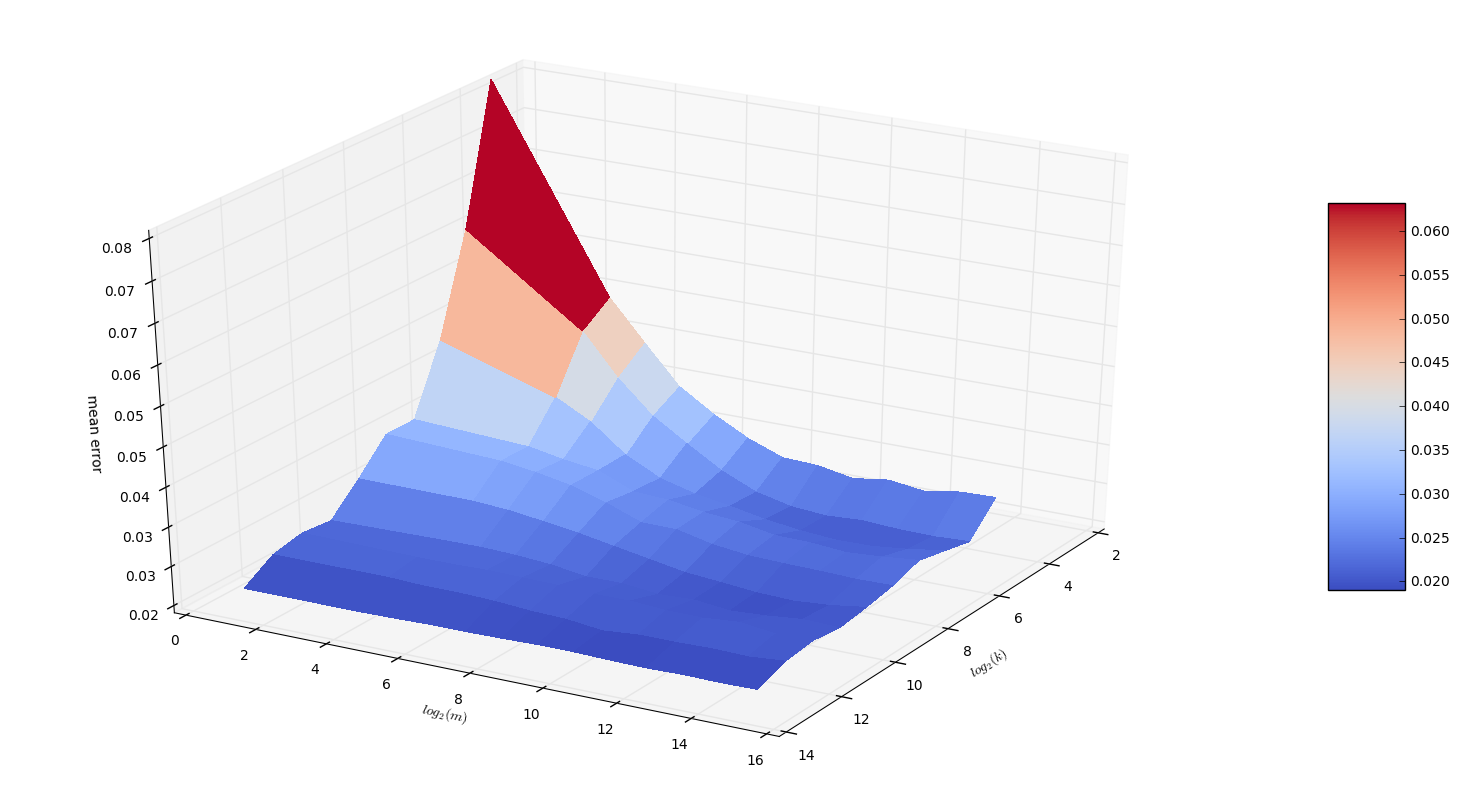

In [6]:
# prepare data for 3D plot:
kmMatrix = []
for k in results['ks']:
    data = []
    for i in range(1,results['iterations']+1):
        iterationRes = []
        for m in results['ms']:
            [accuracy, error] = cmToMeasures(i, k, m)
            iterationRes.append(error)
        data.append(iterationRes)
    kMeans = np.mean(data, axis=0)
    kmMatrix.append(kMeans)
data = np.array(kmMatrix)
ks = []
ms = []
for k in results['ks']:
    for m in results['ms']:
        ks.append(np.log(k) / np.log(2))
        if m == 0:
            ms.append(0)
        else:
            ms.append(np.log(m) / np.log(2))          
ks = np.array(ks).reshape(data.shape)
ms = np.array(ms).reshape(data.shape)


# create the plot:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(ks, ms, data, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(0.02, 0.08)
ax.view_init(30, 30)
ax.set_xlabel('$log_2(k)$')
ax.set_ylabel('$log_2(m)$')
ax.set_zlabel('mean error')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()
